In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.convolution import Gaussian2DKernel, convolve
import astropy.units as u
import pandas as pd

import os
from tqdm import tqdm
import cv2
import pickle
import seaborn as sns
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
PATH = 'D:/Workshop/PhD/Data/ViaLactea/PPMAP_Results/'

In [3]:
model = tf.keras.models.load_model('D:/Workshop/PhD/Models/CNN for fbm Fields/64pxmodel')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0     

In [4]:
spl_H = pickle.load( open( "D:/Workshop/PhD/Models/CNN for fbm Fields/32pxmodel/spl_H.pickle", "rb" ) )
spl_S = pickle.load( open( "D:/Workshop/PhD/Models/CNN for fbm Fields/32pxmodel/spl_S.pickle", "rb" ) )

In [4]:
progress_df = pd.read_csv('D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px/progress.csv')
progress_df

,Direction,H,S,coords
0,l000,0.048362,2.087310,"[359.97972099949186, 0.040683222371426846]"
1,l002,0.376578,0.846815,"[2.1806678248157163, 0.04199591122993718]"
2,l004,0.331084,0.553794,"[4.422267619137547, -0.03956923833120953]"
3,l006,0.270085,0.314479,"[6.621406735872328, -0.04000965792996351]"
4,l008,0.236325,0.326848,"[8.82163708762842, -0.0396701575320798]"
...,...,...,...,...
158,l349,0.308601,0.591260,"[349.8261490006275, -0.03541499993627944]"
159,l352,0.315326,0.317467,"[352.02568077150545, -0.03962198378747212]"
160,l354,0.221952,0.633475,"[354.2244123311806, -0.03977051553483858]"
161,l356,0.285882,0.517383,"[356.3859330004788, 0.031006999951276433]"


In [6]:
coords_list = []
H_list = []
S_list = []

N_p=32
for folder in tqdm(os.listdir(PATH)):
    direction = folder[1:4]
    if not (progress_df['Direction']==f'l{direction}').any():
        hdu = fits.open(f'{PATH}{folder}/l{direction}_cdens.fits')[0]
        wcs = WCS(hdu.header)
        image_array = hdu.data

        img_size_px = np.shape(image_array)
        position_x = int(img_size_px[0]//2)
        position_y = int(img_size_px[0]//2)
        position = (position_x,position_y)
        size = 1000
        size = (size,size)
        cutout = Cutout2D(image_array,position=position,size=size,wcs=wcs)
        centre_coords = pixel_to_skycoord(size[0]/2,size[0]/2, cutout.wcs)
        coords = [centre_coords.l.degree, centre_coords.b.degree]
        img = np.asarray(cutout.data)
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(np.log10(img), origin='lower')
        plt.contour(np.log10(cutout.data))
        plt.colorbar()
        plt.title(f'{direction}')
        plt.savefig(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_nospline/Inputs/{direction}.png')
        plt.close()    

        H_array = []
        S_array = []

        for y in np.arange(np.shape(img)[1]):
            X=[]
            for x in np.arange(np.shape(img)[0]):
                sub_field = img[int(x-N_p/2):int(x+N_p/2),int(y-N_p/2):int(y+N_p/2)]
                if np.shape(sub_field) == (N_p,N_p):
                    sub_field = sub_field/np.nanmax(sub_field) * 255
                    sub_field = np.uint8(sub_field)
                    mask = np.uint8(np.isnan(sub_field))

                    sub_field = cv2.inpaint(sub_field,mask,3,cv2.INPAINT_TELEA)

                    m_1_field = np.mean(sub_field)
                    s_1_field = np.std(sub_field)
                    m_2_field = 0
                    s_2_field = 1/4

                    sub_field = sub_field * s_2_field/s_1_field
                    sub_field += (m_2_field-m_1_field*s_2_field/s_1_field)
                    sub_field[np.where(sub_field>1.)] = 1.
                    sub_field[np.where(sub_field<-1.)] = -1.
                    sub_field = (sub_field-np.min(sub_field))/(np.max(sub_field)-np.min(sub_field))

                    sub_field = np.array(sub_field).reshape(N_p, N_p, 1)
                    X.append(sub_field)

            if len(X) != 0:
                X=np.asarray(X)
                predictions = model.predict(X)
                H_array.append(predictions[:,0])
                S_array.append(predictions[:,1])

        H_array = np.asarray(H_array).T
        S_array = np.asarray(S_array).T
        np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_nospline/H/raw_data/{direction}.txt',H_array)
        np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_nospline/S/raw_data/{direction}.txt',S_array)

        img = img/np.nanmax(img) * 255
        img = np.uint8(img)

        mask = np.uint8(np.isnan(img))
        array_conv=cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)

        centre_coords = pixel_to_skycoord(size[0]/2,size[0]/2, cutout.wcs)

        m_1_field = np.mean(array_conv)
        s_1_field = np.std(array_conv)
        m_2_field = 0
        s_2_field = 1/4

        x = array_conv * s_2_field/s_1_field
        x += (m_2_field-m_1_field*s_2_field/s_1_field)
        x[np.where(x>1.)] = 1.
        x[np.where(x<-1.)] = -1.
        x = (x-np.min(x))/(np.max(x)-np.min(x))

        x = cv2.resize(x, (N_p,N_p))    
        x = x.reshape(1, N_p, N_p, 1)

        preds = model.predict(x)[0]
        H=preds[0]
        
        S=preds[1]
        #S=2*S-spl_S(S)
        
        H_count_array = np.zeros(np.shape(img))
        H_sum_array = np.zeros(np.shape(img))
        for y_i in np.arange(np.shape(H_array)[1]):
            for x_i in np.arange(np.shape(H_array)[0]):
                H_count_array[x_i:x_i+N_p,y_i:y_i+N_p]+=1
                H_sum_array[x_i:x_i+N_p,y_i:y_i+N_p]+=H_array[x_i,y_i]
        H_avg_array = H_sum_array/H_count_array
        
        S_count_array = np.zeros(np.shape(img))
        S_sum_array = np.zeros(np.shape(img))
        for y_i in np.arange(np.shape(S_array)[1]):
            for x_i in np.arange(np.shape(S_array)[0]):
                S_count_array[x_i:x_i+N_p,y_i:y_i+N_p]+=1
                S_sum_array[x_i:x_i+N_p,y_i:y_i+N_p]+=S_array[x_i,y_i]
        S_avg_array = S_sum_array/S_count_array
        
        np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_nospline/H/avg_data/{direction}.txt',H_avg_array)
        np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_nospline/S/avg_data/{direction}.txt',S_avg_array)
        

        
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(H_avg_array)
        plt.contour(np.log10(cutout.data))
        plt.colorbar()
        plt.savefig(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_nospline/H/images/{direction}.png', bbox_inches='tight')
        plt.close()

        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(S_avg_array)
        plt.contour(np.log10(cutout.data))
        plt.colorbar()
        plt.savefig(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_nospline/S/images/{direction}.png', bbox_inches='tight')
        plt.close()
        
        mean_H = np.mean(H_avg_array)
        std_H = np.std(H_avg_array)
        H_avg_array = (H_avg_array-mean_H)/std_H

        mean_S = np.mean(S_avg_array)
        std_S = np.std(S_avg_array)
        S_avg_array = (S_avg_array-mean_S)/std_S
        
        img = np.log10(np.asarray(cutout.data))
        mask = np.uint8(np.isnan(img))
        img=cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)
        mean_img = np.nanmean(img)
        std_img = np.nanstd(img)
        img = (img-mean_img)/std_img
        
        data_cube = np.array([img,H_avg_array,S_avg_array])
    
        pickle_out = open(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_nospline/DataCubes/l{direction}.pickle','wb')
        pickle.dump(data_cube,pickle_out)
        pickle_out.close()

        new_row = {'Direction':f'l{direction}',
                   'H':H,
                   'S':S,
                   'coords':coords}
        progress_df = progress_df.append(new_row,ignore_index=True)
        progress_df.to_csv('D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_nospline/progress.csv',index=False)

100%|██████████████████████████████████████████████████████████████████████████| 163/163 [8:44:38<00:00, 193.12s/it]


In [ ]:
for file in tqdm(os.listdir('D:/Workshop/PhD/Data/ViaLactea/CNN_Results/H/raw_data')):
    direction = file[:3]
    
    hdu = fits.open(f'{PATH}/l{direction}_results/l{direction}_cdens.fits')[0]
    wcs = WCS(hdu.header)

    image_array = hdu.data

    img_size_px = np.shape(image_array)
    position_x = int(img_size_px[0]//2)
    position_y = int(img_size_px[0]//2)
    position = (position_x,position_y)
    size = 1000
    size = (size,size)
    cutout = Cutout2D(image_array,position=position,size=size,wcs=wcs)
    img = np.asarray(cutout.data)
    
    H_array = np.loadtxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/H/raw_data/{file}').T
    H_count_array = np.zeros(np.shape(img))
    H_sum_array = np.zeros(np.shape(img))
    for y in np.arange(np.shape(H_array)[1]):
        for x in np.arange(np.shape(H_array)[0]):
            H_count_array[x:x+128,y:y+128]+=1
            H_sum_array[x:x+128,y:y+128]+=H_array[x,y]
    H_avg_array = H_sum_array/H_count_array
    
    S_array = np.loadtxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/S/raw_data/{file}').T
    S_count_array = np.zeros(np.shape(img))
    S_sum_array = np.zeros(np.shape(img))
    for y in np.arange(np.shape(S_array)[1]):
        for x in np.arange(np.shape(S_array)[0]):
            S_count_array[x:x+128,y:y+128]+=1
            S_sum_array[x:x+128,y:y+128]+=S_array[x,y]
    S_avg_array = S_sum_array/S_count_array
    
    plt.figure(figsize=(1080/144, 1080/144), dpi=144)
    plt.imshow(H_avg_array)
    plt.contour(np.log10(cutout.data))
    plt.colorbar()
    plt.savefig(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/H/images/{direction}.png', bbox_inches='tight')
    plt.close()
    
    plt.figure(figsize=(1080/144, 1080/144), dpi=144)
    plt.imshow(S_avg_array)
    plt.contour(np.log10(cutout.data))
    plt.colorbar()
    plt.savefig(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/S/images/{direction}.png', bbox_inches='tight')
    plt.close()
    
    np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/H/avg_data/{direction}',H_avg_array)
    np.savetxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/S/avg_data/{direction}',S_avg_array)

In [5]:
directions = progress_df['Direction'].tolist()
for direction in tqdm(directions):
    direction = direction[1:]
    
    H_array = np.loadtxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px/H/avg_data/{direction}.txt')
#     mean_H = np.mean(H_array)
#     std_H = np.std(H_array)
#     H_array = (H_array-mean_H)/std_H
    
    S_array = np.loadtxt(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px/S/avg_data/{direction}.txt')
#     mean_S = np.mean(S_array)
#     std_S = np.std(S_array)
#     S_array = (S_array-mean_S)/std_S
    
    hdu = fits.open(f'D:/Workshop/PhD/Data/ViaLactea/PPMAP_Results/l{direction}_results/l{direction}_cdens.fits')[0]
    wcs = WCS(hdu.header)
    image_array = hdu.data
    img_size_px = np.shape(image_array)
    position_x = int(img_size_px[0]//2)
    position_y = int(img_size_px[0]//2)
    position = (position_x,position_y)
    size = 1000
    size = (size,size)
    cutout = Cutout2D(image_array,position=position,size=size,wcs=wcs)
    x = np.arange(0,size[0])
    y = np.arange(0,size[1])
    xx, yy = np.meshgrid(x, y)
    coords_grid = pixel_to_skycoord(xx,yy, cutout.wcs)
    img = np.log10(np.asarray(cutout.data))
    mask = np.uint8(np.isnan(img))
    img=cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)
    mean_img = np.nanmean(img)
    std_img = np.nanstd(img)
    imgstd = (img-mean_img)/std_img
    
    data_cube = np.array([img,imgstd,H_array,S_array,coords_grid.l.degree,coords_grid.b.degree])

    pickle_out = open(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px/DataCubes/l{direction}.pickle','wb')
    pickle.dump(data_cube,pickle_out)
    pickle_out.close()
coords_grid.l.degree

100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [11:38<00:00,  4.29s/it]


array([[359.41922827, 359.41756164, 359.41589501, ..., 357.75736018,
        357.75569354, 357.7540269 ],
       [359.41922828, 359.41756165, 359.41589502, ..., 357.75736016,
        357.75569352, 357.75402688],
       [359.4192283 , 359.41756167, 359.41589504, ..., 357.75736015,
        357.75569351, 357.75402687],
       ...,
       [359.41924294, 359.41757628, 359.41590962, ..., 357.75734571,
        357.75567904, 357.75401237],
       [359.41924295, 359.41757629, 359.41590963, ..., 357.7573457 ,
        357.75567903, 357.75401236],
       [359.41924297, 359.41757631, 359.41590965, ..., 357.75734568,
        357.75567901, 357.75401235]])

In [5]:
the_cube = pickle.load(open(f'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/DataCubes/l000.pickle','rb'))
n_bands = np.shape(the_cube)[0]
MB_img = np.zeros((1000,1000,n_bands))
for i in range(n_bands):
    MB_img[:,:,i] = the_cube[i]

In [6]:
MB_matrix = np.zeros((MB_img[:,:,0].size,n_bands))

for i in range(n_bands):
    MB_array = MB_img[:,:,i].flatten()  # covert 2d to 1d array 
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
    MB_matrix[:,i] = MB_arrayStd
MB_matrix.shape

(1000000, 3)

In [7]:
np.set_printoptions(precision=3)
cov = np.cov(MB_matrix.transpose())

# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)

print("Eigenvalues:\n\n", EigVal,"\n")

Eigenvalues:

 [2.076 0.347 0.577] 



In [8]:
# Ordering Eigen values and vectors
order = EigVal.argsort()[::-1]
EigVal = EigVal[order]
EigVec = EigVec[:,order]

#Projecting data on Eigen vector directions resulting to Principal Components 
PC = np.matmul(MB_matrix,EigVec)   #cross product

Text(0.5, 0.98, 'Pair plot of PCs')

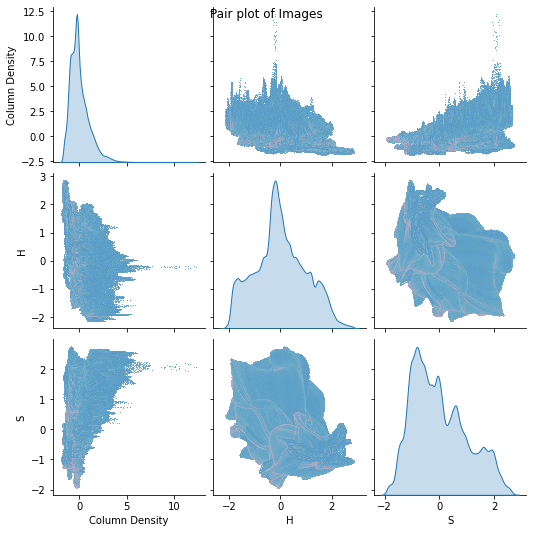

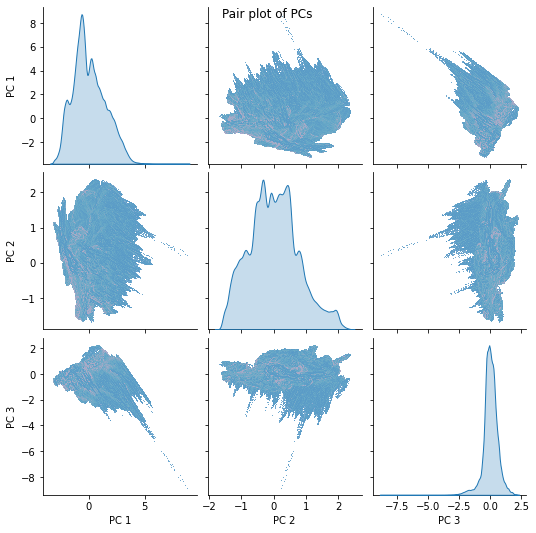

In [12]:
Bandnames = ['Column Density','H','S']
a = sns.pairplot(pd.DataFrame(MB_matrix,
                columns = Bandnames),
                 diag_kind='kde',plot_kws={"s": 1})
a.fig.suptitle("Pair plot of Images")

PCnames = ['PC 1','PC 2','PC 3']
b = sns.pairplot(pd.DataFrame(PC,
                columns = PCnames),
                 diag_kind='kde',plot_kws={"s": 1})
b.fig.suptitle("Pair plot of PCs")

In [ ]:
plt.figure()
plt.hist(H_list)
plt.title('H')
plt.show()

plt.figure()
plt.hist(S_list)
plt.title('S')
plt.show()

In [ ]:
latitudes = np.roll(np.array(coords_list)[:,0],-1)
longitudes = np.roll(np.array(coords_list)[:,1],-1)

H_list = np.roll(H_list, -1)
S_list = np.roll(S_list, -1)

In [ ]:
plt.plot(longitude,H_list)

In [ ]:
plt.plot(longitude,S_list)

In [ ]:
img_shape = img.shape

size = 128 # window size i.e. here is 3x3 window

shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
strides = 2 * img.strides
patches = np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)
patches = patches.reshape(-1, size, size)

output_img = np.array([some_func(roi) for roi in patches])